In [1]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import special
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import torch_utils

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

In [2]:
M = 16
k = int(np.log2(M))
n = 1
TRAINING_SNR = 10
one_hot = False
sigma_pi = np.sqrt(0.02)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(k/n)*ebno) 
    return noise_std

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

In [4]:
class AWGNChannelLayer(nn.Module):
    def __init__(self, noise_std):
        super().__init__()
        self.noise_std = noise_std

    def forward(self, x):
        noise = torch.randn_like(x) * self.noise_std
        return x + noise


class Encoder(nn.Module):
    def __init__(self, M, n, one_hot=True):
        super().__init__()
        self.one_hot = one_hot
        if not one_hot:
            self.embedding = nn.Embedding(M, M)
        self.fc1 = nn.Linear(M, M)
        self.fc2 = nn.Linear(M, 2 * n)
        
    def power_constraint(self, codes):
        codes_mean = torch.mean(codes)
        codes_std  = torch.std(codes)
        codes_norm = (codes-codes_mean)/ codes_std
        
        return codes_norm

    def forward(self, x):
        if not self.one_hot:
            x = self.embedding(x)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 2, n)
        x = self.power_constraint(x)
        return x

class Decoder(nn.Module):
    def __init__(self, M, n):
        super().__init__()
        self.fc1 = nn.Linear(2 * n, M)
        self.fc2 = nn.Linear(M, M)

    def forward(self, x):
        x = x.view(-1, 2 * n)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        return x


noise_std = EbNo_to_noise(TRAINING_SNR)  # Assuming the function is defined

channel = AWGNChannelLayer(noise_std).to(device)

In [5]:
def policy_function(x_pert, x_enc, sigma_pi):
    sigma_pi = torch.as_tensor(sigma_pi)
    x_scaled = x_enc * torch.sqrt(1.0 - sigma_pi**2)
    policy = -(1 / sigma_pi**2) * torch.norm(x_pert - x_scaled, dim=1)**2
    return policy

def perturbation(x, sigma_pi):
    x = torch.as_tensor(x)
    sigma_pi = torch.as_tensor(sigma_pi)
    x_scaled = x * torch.sqrt(1 - sigma_pi**2)
    z = torch.randn_like(x) * sigma_pi
    return x_scaled + z

In [40]:
def B_Ber_m(input_msg, msg, one_hot):
    '''Calculate the Batch Bit/Symbol Error Rate'''
    batch_size = input_msg.shape[0]
    
    if one_hot:
        pred_error = torch.ne(torch.argmax(msg, dim=1), torch.argmax(input_msg, dim=1))
    else:
        pred_error = torch.ne(input_msg.view(-1, batch_size), torch.argmax(msg, dim=1))
    
    bber = torch.mean(pred_error.float())
    return bber

In [7]:
def random_sample(batch_size=32):
    if one_hot:
        msg = torch.eye(M)[torch.randint(high=M, size=(batch_size,))]
    else:
        msg = torch.randint(low=0, high=M, size=(batch_size,1))
        
    return msg

In [8]:
def test_encoding(encoder, M=16, n=1):
    if one_hot:
        inp = torch.eye(M).to(device)
    else:
        inp = torch.arange(0,M).to(device)
    coding = encoder(inp)
    coding = coding.cpu().detach().numpy()
    fig = plt.figure(figsize=(2,2))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()

In [47]:
def categorical_crossentropy_loss(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true)

def categorical_crossentropy_loss_pE(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true, reduction='none')

def sparse_categorical_crossentropy_loss(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true)

def sparse_categorical_crossentropy_loss_pE(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true, reduction='none')

if one_hot:
    loss_fn = categorical_crossentropy_loss
    loss_fn_pE = categorical_crossentropy_loss_pE
else:
    loss_fn_pE = sparse_categorical_crossentropy_loss_pE
    loss_fn = sparse_categorical_crossentropy_loss
    
class RunningMean:
    """Class to calculate the running mean of a value."""

    def __init__(self):
        self.count = 0
        self.mean = 0

    def update(self, value):
        self.mean = (self.count * self.mean + value) / (self.count + 1)
        self.count += 1

    def reset(self):
        self.count = 0
        self.mean = 0


In [12]:
def train_alternate_RL(encoder, decoder, channel, loss_fn, loss_fn_pE, policy_function, perturbation, random_sample, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05, plot_encoding=False):
    optimizer_en = optim.Adam(encoder.parameters(), lr=learning_rate)
    optimizer_de = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    for epoch in range(1, n_epochs + 1):
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
        progress_bar = tqdm(range(1, n_steps + 1), desc="Training")
        
        for step in progress_bar:
            X_batch = random_sample(batch_size).to(device)
            X_batch = X_batch.squeeze()
            optimizer_ae.zero_grad()

            x_enc = encoder(X_batch)
            y_recv = channel(x_enc)
            y_pred = decoder(y_recv)
            loss_dec = loss_fn(y_pred, X_batch)

            loss_dec.backward()
            optimizer_de.step()

            # Draw another sample, as in the paper
            X_batch = random_sample(batch_size).to(device)
            X_batch = X_batch.squeeze()
            optimizer_ae.zero_grad()

            x_enc = encoder(X_batch)
            x_enc = x_enc.view(-1, 2 * n)
            x_pert = perturbation(x_enc, sigma_pi)
            x_pert_s = x_pert.view(-1, 2, n)
            y_recv = channel(x_pert_s)
            y_pred = decoder(y_recv)

            loss = loss_fn_pE(y_pred, X_batch)
            policy = policy_function(x_pert.detach(), x_enc, sigma_pi)
            temp = (loss.detach() * policy).mean()
            temp.backward()

            optimizer_en.step()
            loss_cr = loss.mean().item()
            BER = B_Ber_m(X_batch, y_pred, one_hot).item()

            progress_bar.set_postfix(epoch=epoch, loss=loss_cr, BER=BER)
            
        if plot_encoding:
            test_encoding(encoder, M, n)

In [13]:
def train_alternate(encoder, decoder, channel, loss_fn, loss_fn_pE, policy_function, perturbation, random_sample, n_epochs=5, n_steps=20, batch_size=200, learning_rate=0.05, plot_encoding=False):
    optimizer_en = optim.Adam(encoder.parameters(), lr=learning_rate)
    optimizer_de = optim.Adam(decoder.parameters(), lr=learning_rate)

    loss_history = []

    for epoch in range(1, n_epochs + 1):
        print("Training Bob in Epoch {}/{}".format(epoch, n_epochs))
        progress_bar = tqdm(range(1, n_steps + 1), desc="Training")
        
        for step in progress_bar:
            X_batch = random_sample(batch_size).to(device)
            X_batch = X_batch.squeeze()
            optimizer_ae.zero_grad()

            x_enc = encoder(X_batch)
            y_recv = channel(x_enc)
            y_pred = decoder(y_recv)
            loss_dec = loss_fn(y_pred, X_batch)

            loss_dec.backward()
            optimizer_ae.step()

            X_batch = random_sample(batch_size).to(device)
            X_batch = X_batch.squeeze()
            optimizer_de.zero_grad()

            x_enc = encoder(X_batch)

            y_recv = channel(x_enc)
            y_pred = decoder(y_recv)
            
            loss = loss_fn(y_pred, X_batch)
            loss.backward()

            optimizer_en.step()
            loss_cr = loss.mean().item()
            BER = B_Ber_m(X_batch, y_pred, one_hot).item()

            progress_bar.set_postfix(epoch=epoch, loss=loss_cr, BER=BER)

        if plot_encoding:
            test_encoding(encoder, M, n)

In [45]:
def Test_AE(encoder, decoder, random_sample, B_Ber_m):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
    progress_bar = tqdm(range(len(snr_range)), desc="Testing")
    mean = RunningMean()

    for db in progress_bar:
        bber = None
        for it in range(1, 500*db):
            noise_std = EbNo_to_noise(snr_range[db])
            X_batch = random_sample(1000).to(device)
            code_word = encoder(X_batch)
            rcvd_word = code_word + torch.randn_like(code_word).to(device) * noise_std
            dcoded_msg = decoder(rcvd_word)
            bber = B_Ber_m(X_batch, dcoded_msg, one_hot)
            mean.update(bber.cpu().detach().numpy())

            progress_bar.set_postfix(DB=snr_range[db], BER=mean.mean)

        bber_vec[db] = mean.mean
        mean.reset()

    return (snr_range, bber_vec)

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_snr_ber(array_1, array_2):
    """
    Plots SNR vs. BER for two arrays using Seaborn.
    """

    # Unpack the data from the input tuples
    snr_1, ber_1 = array_1
    snr_2, ber_2 = array_2

    # Detach the BER tensors and convert to NumPy arrays
    #ber_1 = [ber.cpu().detach().numpy() for ber in ber_1]
    #ber_2 = [ber.cpu().detach().numpy() for ber in ber_2]
    
    # Flatten the BER data
    ber_1 = np.ravel(ber_1)
    ber_2 = np.ravel(ber_2)
    
    # Filter out zero and negative BER values
    snr_1 = snr_1[ber_1 > 0]
    ber_1 = ber_1[ber_1 > 0]
    snr_2 = snr_2[ber_2 > 0]
    ber_2 = ber_2[ber_2 > 0]

    # Create plot
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_yscale('log')
    ax.set_xlim((snr_1.min(), snr_1.max()))
    sns.lineplot(x=snr_1, y=ber_1, label="RL", marker='o', markersize=6, ax=ax)
    sns.lineplot(x=snr_2, y=ber_2, label="AE", marker='s', markersize=6, ax=ax)
    ax.grid(which='both', linestyle=':', alpha=0.5)

    # Set labels and legend
    ax.set_xlabel("EbN0")
    ax.set_ylabel("BER")
    ax.set_title("SNR vs. BER")
    ax.legend()

    plt.show()

Training Bob in Epoch 1/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training Bob in Epoch 2/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training Bob in Epoch 3/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

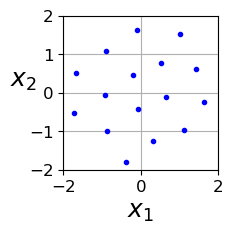

Training Bob in Epoch 1/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training Bob in Epoch 2/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training Bob in Epoch 3/3


Training:   0%|          | 0/500 [00:00<?, ?it/s]

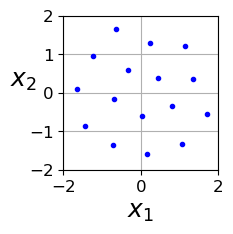

In [16]:
channel = AWGNChannelLayer(noise_std).to(device)

encoder_RL = Encoder(M, n, one_hot).to(device)
decoder_RL = Decoder(M, n).to(device)

encoder_AE = Encoder(M, n, one_hot).to(device)
decoder_AE = Decoder(M, n).to(device)

train_alternate_RL(encoder_RL, decoder_RL, channel, loss_fn, loss_fn_pE, policy_function, perturbation, random_sample,n_epochs=3, n_steps=500, batch_size=500, learning_rate=0.005,plot_encoding=False)
test_encoding(encoder_RL, M, n)

train_alternate(encoder_AE, decoder_AE, channel, loss_fn, loss_fn_pE, policy_function, perturbation, random_sample,n_epochs=3, n_steps=500, batch_size=500, learning_rate=0.005,plot_encoding=False)
test_encoding(encoder_AE, M, n)

In [48]:
output_RL = Test_AE(encoder_RL, decoder_RL, random_sample, B_Ber_m)
output_AE = Test_AE(encoder_AE, decoder_AE, random_sample, B_Ber_m)

Testing:   0%|          | 0/31 [00:00<?, ?it/s]

Testing:   0%|          | 0/31 [00:00<?, ?it/s]

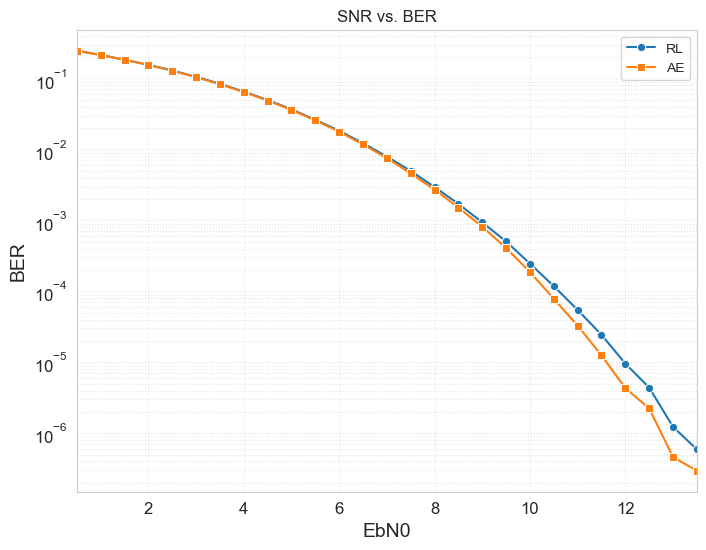

In [55]:
plot_snr_ber(output_RL, output_AE)